## Data Exploration

This right here is an optional notebook, but a crucial part of the data science/ML pipeline is understanding the data that you work with. It's important to know the different relationships in the data, what your downstream task is, and the different processing techniques available to you. 

For the purposes of this workshop, we're going to be working with the Perceptual Voice Qualities Database (PVQD). It's a dataset that has contains speakers enunciating two vowels /a/ and /i/, and then speaking a list of five sentences. Three clinicians then rate each sample across 6 perceptual qualities, of which 5 are given to you. This rating is done on a 1-100 scale. The ratings are provided in `audio_ml_workshop_2023/data/train_test_split/`, and the audio files are provided in `audio_ml_workshop_2023/data/audio_clips/`.

Before running any analysis, it's good to know what data you're working with. I provided the demographics and diagnosis info in the `demographics.csv` file. We'll start by exploring the metadata of the data, and then get into the actual audio data from there.

In [4]:
import os 
import sys
sys.path.append("../")

import numpy as np 
import pandas as pd 
import IPython
import matplotlib.pyplot as plt
import seaborn as sns

# Load in Torch, we're not doing much with it here!
import torch
import torchaudio

It's always important to have a train-validation-test split. In my opinion, you should at the very least perform a train-test split **before conducting any analysis**. The test set should **never** be touched during training and analysis of data, and only used for evaluation at the end of a project. This way you have a set of held-out data that you know you haven't been overfitting to. 

In this workshop, I've provided a 80-10-10 train-val-test split for you. For this data exploration, we're just going to look at the training data. Let's load it in now! We'll load in the training data's perceptual qualities (in `y_train.csv`) and the demographics data.

In [66]:
# Load in the demographics data
demo_df = pd.read_csv("../data/pvqd/demographics.csv")

# Load in the training data's perceptual qualities labels
pq_train = pd.read_csv("../data/pvqd/train_test_split/y_train.csv", index_col = 0)

If you were finding a dataset online, you might know the answers to these questions already if they were provided by the dataset's creators. But let's go ahead and start with the basics. You might not always know how much data is in the dataset, and how that data splits along different axes of interest, such as gender and age. I know I just said to never use the entire dataset when conducting analysis, but computing high-level metadata infomration and understanding how your data is structured is necessary for the entire pipeline. So we'll compute these high-level statistics now.

First question! What do the demographics of the dataset look like?

In [5]:
# Display the first 10 data points
demo_df.head(10)

,Participant ID,Gender,Age,Diagnosis
0,BL01,M,46,NaN
1,BL02,F,76,NaN
2,BL03,F,88,NaN
3,BL04,F,42,NaN
4,BL05,F,75,NaN
5,BL06,F,65,NaN
6,BL07,F,24,NaN
7,BL08,F,27,NaN
8,BL09,M,70,NaN
9,BL10,F,21,NaN


Already we see something interesting. We have the participant id, which, because we do speech research, I'm going to call the speaker_id from now on. We have their gender and age, and another column that lists diagnoses. We see that the first 10 entries are all NaN--weird. We'll get back to that later. How you deal with missing values is an **incredibly** important modeling choice. 

Let's see how much data we have first.

In [7]:
# Report the Length of the Data
total_participants = len(demo_df)
print("Total Number of Participants %s" % total_participants)

# TODO: Compute the number of participants in the training set
training_num = len(pq_train)
print("Training Set Size: %s" % training_num)


Total Number of Participants 297
Training Set Size: 235


So we have 297 participants. Starting to get a sense of our data, but we're still not really sure at all about things. Let's delve into the demographics data a bit more. The dataframe has three columns: age, gender, and diagnosis. Let's try grouping the data by gender and count who all is in the dataset.

In [9]:
# A group-by operation: Calculate aggregate statistics and other operations on data points with the same value for a column! 
# Let's count the number of men and women in the dataframe

demo_df.groupby("Gender").agg("count").reset_index()

,Gender,Participant ID,Age,Diagnosis
0,F,141,141,126
1,Female,13,13,13
2,M,82,82,77
3,Male,1,1,1
4,f,29,29,29
5,female,13,13,13
6,m,8,8,8
7,male,10,10,10


### Soooooo, that's not good at all!!! 

It turns out that the demographics csv isn't as clean as we might have hoped. We're going to have to **clean** the dataframe so we can get the analysis we want. 

**Arguably, data cleaning and collection is the most labor-intensive part of many ML pipelines.**

At least in my opinion, others in the lab might disagree!

### So what do we do?

First off, including participant id, age, and diagnosis in the count seems to be really messy. Firstly, if we're just counting values, why is the diagnosis column different than the age column?? (Hint: it's cause of those NaN's from before). That won't do. Let's just take the Participant ID and Gender columns.


In [22]:
demo_df[["Participant ID", "Gender"]]

KeyError: "['Participant ID'] not in index"

Hahahahahahahaha--you must be joking. What the *** does it mean that `['Participant ID'] not in index`??? It's right there in the headers. Let's print out the column names. 

In [11]:
print(demo_df.columns)

Index(['Participant ID ', 'Gender', 'Age', 'Diagnosis '], dtype='object')


Ok, so. Whoever made this csv (me) didnt strip the whitespace in the "Participant ID " column name, resulting in an error. 

Let's try including the whitespace and trying again.

In [14]:
demo_df[["Participant ID ", "Gender"]].head(3)

,Participant ID,Gender
0,BL01,M
1,BL02,F
2,BL03,F


Stupid. But ok, we got the subset of the dataframe we want to analyze. Now we have to fix that Gender column. 

Luckily for us, Pandas as a pretty nice way of dealing with strings. If you have a column that's a column of strings, Pandas let's you perform a variety of modfications and queries on those strings via the `.str.`. I've provided the code for fixing the Gender column below!

We'll also be using a handy function called `Series.map` that allows you to apply a dictionary or Series to a column in Pandas. We'll take advantage of this to fix the Gender column!

In [18]:
# Process the gender column, let's just make gender either a 'm' or 'f' value
lowered_gender = demo_df["Gender"].str.lower()

gender_dict = {
    "female": "f",
    "male": "m",
    'm': 'm',
    "f": 'f'
}

lowered_gender = lowered_gender.map(gender_dict)

demo_df["Gender"] = lowered_gender

Let's try selecting only two columns and performing the groupby like before!

In [21]:
demo_df[["Participant ID ", "Gender"]].groupby("Gender").agg("count").reset_index()

,Gender,Participant ID
0,f,196
1,m,101


It worked!! Now we know that the dataset is roughly split up into 2/3 women and 1/3 men. 

### What else can we do with demographics?

Well we still have the age and diagnoses column, let's try exploring those next.

For age, let's plot some histograms! There's a lot of numbers and the visualizations will make it easier.

<Axes: xlabel='Age', ylabel='Count'>

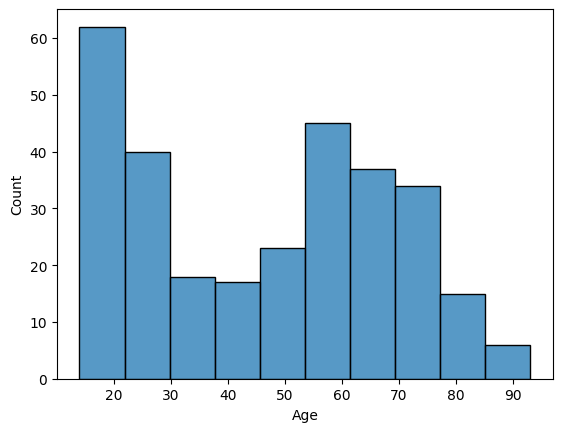

In [23]:
sns.histplot(data=demo_df, x="Age")

Let's explore out some other important distributional data for fun!

In [26]:
print("Mean Age %s " % demo_df["Age"].mean())
print("Median Age %s " % demo_df["Age"].median())

#TODO: Compute the Max and Min age
print("Max Age %s " % demo_df["Age"].max())
print("Min Age %s " % demo_df["Age"].min())

Mean Age 46.72727272727273 
Median Age 48.0 
Max Age 93 
Min Age 14 


Let's not just silo each demographic detail away from one another, let's look to see how the histogram and statistics change across gender!

<Axes: xlabel='Age', ylabel='Count'>

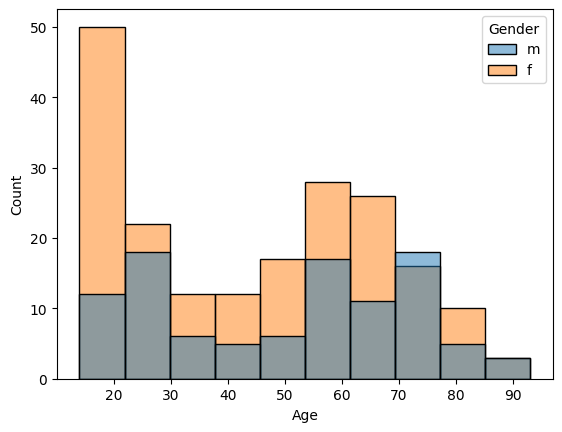

In [27]:
sns.histplot(data=demo_df, x="Age", hue="Gender")

In [36]:
# TODO: Modify the below code to calculate the min and the max as well!
demo_df[["Gender", "Age"]].groupby("Gender").agg(["mean", "median"]).reset_index()

Gender        Age       
               mean median
0      f  44.913265   46.0
1      m  50.247525   56.0

So that's interesting! The male participants are older on average. We're learning things about the data here. 

How will this finding impact our analysis? It might, it might not. One application I could think of, off the top of my head, is that if we wanted to make sure that we made an train-test split, we might want to make sure that the number of samples from male and female participants is equal in the test set. If we take a completely random split, it won't be. 

Let's try looking at that Diagnosis column now. Let's try doing what we did for age and gender, but now looking at diagnosis and age.

In [41]:
# Looking at the Diagnosis column--turns ou it was the same thing
demo_df[["Diagnosis ", "Gender"]].groupby("Diagnosis ").agg("count")

,Gender
Diagnosis,
Adductor spasmodic dysphonia,4
Atrophy,7
"Atrophy, MTD",3
Bilareral phonotraumatic Lesion,1
Bilateral VF paralysis,1
...,...
vocal fold nodules,1
vocal fold parlysis (L),1
vocal fold polyp,1


Uhhh, that's a of values, let's try to split it up a bit further. Just how many diagnoses are there?

In [42]:
demo_df["Diagnosis "].unique()

array([nan, 'N', 'Y', 'Vocal fold cyst', 'vocal fold parlysis (L)',
       'Vocal fold scar', 'Bilareral phonotraumatic Lesion',
       'Phonotraumatic Lesion', 'Vocal Fold Paralysis', 'Vocal Fold Scar',
       'Vocal Fold Edema', 'Vocal Fold Polyp', 'stenosis',
       'vocal fold nodules', 'vocal fold lesions', 'Atrophy',
       'vocal fold polyp', 'vocal tremor', 'atrophy', 'phonotrauma ',
       'vocal fold edema', 'VFParesis', 'Vfpaolyp', 'Vflesions',
       'VFPAralysis', 'Vfscar', 'VFPolyp', "Reinke's Edema",
       'atrophy/hypomobility', 'MTD', 'ulcerative laryngitis ', 'lesions',
       'vocal process granulomas',
       'Laryngeal stenosis, bilateral VF paralysis',
       'MTD, unilateral VF paralysis', 'PVFM', 'Bilateral VF paresis',
       'Unilateral VF paralysis, atrophy',
       'atrophy, unilateral Vf paralysis', "Parkinson's disease, atrophy",
       "Parkinson's disease ", 'Unilateral VF paralysis', 'Leukoplakia',
       'Tremor', 'Glottic Cancer', 'Atrophy, MTD', "Pa

That's a lot. Let's try and aggregate the diagnoses. We're going to assume that "N" means that the person doesn't have a diagnosis.

Here's a question though, can we conclude the same for those with a diagnosis of nan? 

No. Not at all. It seems like the PVQD has aggregated across multiple datasets, so it's possible that the speakers with nan values come from a dataset where diagnoses were not provided. We can (and will!) explore this in data later.

For the time being, let's just group the data into `nan, N, Y`. We can just use `.map()` like before! This time we'll write a function.

In [49]:
# Create a function to apply to the column
def process_diagnosis(diagnosis):
    if pd.isnull(diagnosis):
        return np.nan
    if diagnosis == "N":
        return "N"
    else:
        return "Y"

demo_df["Diagnosis "] = demo_df["Diagnosis "].map(process_diagnosis)

In [50]:
# Let's see if it worked!
demo_df["Diagnosis "].unique()

array([nan, 'N', 'Y'], dtype=object)

Ok awesome! It worked!

Note: It's generally a bad idea to just set the old dataframe column to a new one like I did here. First off, we're throwing away all the specific diagnosis data! That is super helpful to know and probably would lead to more specific insights. Secondly, I knew that my function was going to work, but, in reality, don't be so sure. This is bad and don't do this usually!

Moving on, let's do some more data visualizations :)

In [61]:
## We can't visualize nan data, so let's not consider those rows
# ~ is a way to invert a numpy array/pandas series of boolean values. A handy trick
diagnosis_df = demo_df[~pd.isnull(demo_df["Diagnosis "])]
diagnosis_df.shape

(277, 4)

<Axes: xlabel='Age', ylabel='Count'>

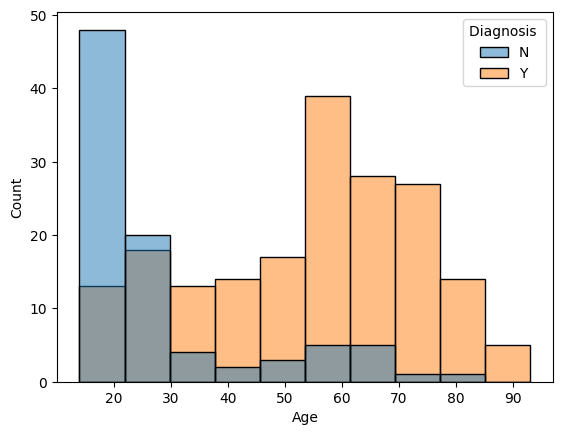

In [62]:
sns.histplot(data=diagnosis_df, x="Age", hue="Diagnosis ")

In [60]:
## TODO: Compute the Mean/Median age for those with or without diagnoses

So this is a super interesting plot! Here we see that those with diagnoses are present across all ages, definitely skewing a bit older. For those without diagnoses, young people are highly represented while older folks aren't really represented much at all! 

This is an incredibly important finding to keep in mind. Ideally when performing statistical analyses or learning a model, we'd want to keep a particular trait fixed and study variation along other axes. If we keep a trait fixed like age, but then don't have the data to study variation across diagnoses, it's quite possible (and pretty likely) that our results will not generalize. Understanding what data you do and don't have will affect what conclusions you can draw from a given dataset. 

### Let's start looking at the actual Perceptual Quality (PQ) labels now

Now, we'll only look at the training data. When to make the choice to switch to a train-test split can be slightly arbitrary, but usually a rule of thumb is that, once you start observing the labels you wish to learn and the features you wish to train on, it's a good idea to start working with a train-test split. Other folks will disagree on this, and we haven't really done enough exploration here--we haven't even looked at the audio data yet--but I want to expose you all to the magical world of dataframe joins and clustering. So, we're going to gloss over the specifics of coming up with a train-val-test split and just work with the one that's given here.

Just know that the specifics of how you actually make a train-test split can vary depending on the structure of your data and the task you wish to solve. And, in my opinion, you should try to make a train-val-test split as soon as possible. 

All that said, let's look at the training data now.

In [67]:
pq_train.head()

,File,Breathiness,Loudness,Pitch,Roughness,Strain
0,LA7005,7.000000,7.333333,7.000000,8.500000,8.000000
1,PT116,31.833333,12.333333,6.000000,29.500000,7.333333
2,PT034,43.166667,26.666667,61.166667,34.000000,30.333333
3,SJ6006,4.375000,5.125000,0.250000,3.750000,6.875000
4,PT005,5.500000,7.000000,12.000000,3.833333,4.500000


We see some similar stuff as before! Here, the File column is the same as the participant ID column--well, hopefully. And then we see the 5 perceptual qualities we're going to wish to learn. Let's see if we can get a combined dataframe first. 

I'm going to make the join easier and rename the "Participant ID " column to "File". Performing a left join, where the `pq_train` dataframe is the left dataframe, will ensure that only the speakers in the training set are matched with their demographic info.

We're also just going to work with the diagnosis dataframe, since we want to explore the relationship between perceptual qualities and a diagnosis.

In [74]:
# Rename column
diagnosis_df = diagnosis_df.rename(columns={"Participant ID ": "File"})

In [76]:
# Merge the two dataframes using a left join
matched_df = pq_train.merge(diagnosis_df, how="left", on="File")
matched_df.head()

,File,Breathiness,Loudness,Pitch,Roughness,Strain,Gender,Age,Diagnosis
0,LA7005,7.000000,7.333333,7.000000,8.500000,8.000000,f,52.0,Y
1,PT116,31.833333,12.333333,6.000000,29.500000,7.333333,f,81.0,Y
2,PT034,43.166667,26.666667,61.166667,34.000000,30.333333,f,80.0,Y
3,SJ6006,4.375000,5.125000,0.250000,3.750000,6.875000,f,17.0,N
4,PT005,5.500000,7.000000,12.000000,3.833333,4.500000,f,58.0,Y


Awesome! So we see above the pq_train dataframe with the demographic columns tacked onto the end there! Let's make sure that everything was joined correctly. If they weren't, some of the values in the Gender, Age, or Diagnosis columns would be NaN, so let's check those.

In [77]:
matched_df[pd.isnull(matched_df["Gender"])]

,File,Breathiness,Loudness,Pitch,Roughness,Strain,Gender,Age,Diagnosis
11,SJ4002,2.250000,3.500000,0.125000,13.375000,10.500000,NaN,NaN,NaN
13,SJ30005,3.250000,3.375000,0.250000,10.625000,8.500000,NaN,NaN,NaN
14,SJ4007,8.000000,13.750000,0.250000,16.750000,7.000000,NaN,NaN,NaN
23,BL14,2.333333,8.833333,9.333333,11.666667,7.833333,NaN,NaN,NaN
30,SJ4008,17.500000,0.250000,0.125000,9.125000,9.375000,NaN,NaN,NaN
40,BL18,9.000000,4.833333,8.333333,18.000000,15.000000,NaN,NaN,NaN
53,BL02,54.833333,54.833333,36.166667,65.000000,58.333333,NaN,NaN,NaN
80,BL12,34.000000,20.000000,17.666667,39.000000,30.333333,NaN,NaN,NaN
82,SJ2003,5.500000,0.666667,0.500000,5.000000,0.500000,NaN,NaN,NaN
88,SJ4003,18.500000,12.875000,9.875000,7.625000,9.625000,NaN,NaN,NaN


*Screams internally*

Ok, ok, ok. Something happened here that broke the join. Clearly a bunch of files weren't stored correctly.

Normally, trying to figure this out would be a pain, but my years of experience of trying to join tables based on string values has taught me a thing or two. When trying to join on strings, joins will fail if the string is not a perfect match. Similar to how an extra space menat "Participant ID" wasn't in the axis, if the string is not the same case, or has an extra whitespace, the join will break. Let's try reformating `diagnosis_df` and see if that fixes things.

Using the str module, can you uppercase the font and strip the whitespace?

In [80]:
# TODO: uppercase the File column and strip whitespace
diagnosis_df["File"] = diagnosis_df["File"].str.upper().str.strip()

In [81]:
# Merge the two dataframes using a left join
matched_df = pq_train.merge(diagnosis_df, how="left", on="File")
matched_df.head()

,File,Breathiness,Loudness,Pitch,Roughness,Strain,Gender,Age,Diagnosis
0,LA7005,7.000000,7.333333,7.000000,8.500000,8.000000,f,52.0,Y
1,PT116,31.833333,12.333333,6.000000,29.500000,7.333333,f,81.0,Y
2,PT034,43.166667,26.666667,61.166667,34.000000,30.333333,f,80.0,Y
3,SJ6006,4.375000,5.125000,0.250000,3.750000,6.875000,f,17.0,N
4,PT005,5.500000,7.000000,12.000000,3.833333,4.500000,f,58.0,Y


In [82]:
matched_df[pd.isnull(matched_df["Gender"])]

,File,Breathiness,Loudness,Pitch,Roughness,Strain,Gender,Age,Diagnosis
23,BL14,2.333333,8.833333,9.333333,11.666667,7.833333,NaN,NaN,NaN
40,BL18,9.000000,4.833333,8.333333,18.000000,15.000000,NaN,NaN,NaN
53,BL02,54.833333,54.833333,36.166667,65.000000,58.333333,NaN,NaN,NaN
80,BL12,34.000000,20.000000,17.666667,39.000000,30.333333,NaN,NaN,NaN
126,BL13,19.000000,8.000000,18.833333,8.333333,19.500000,NaN,NaN,NaN
132,BL20,18.500000,16.333333,15.333333,23.833333,28.500000,NaN,NaN,NaN
139,BL01,4.500000,9.666667,6.333333,9.500000,4.500000,NaN,NaN,NaN
144,BL05,40.166667,29.500000,15.333333,34.666667,26.666667,NaN,NaN,NaN
154,BL16,22.500000,23.833333,11.333333,19.333333,23.166667,NaN,NaN,NaN
156,BL03,32.333333,37.166667,41.166667,56.166667,44.500000,NaN,NaN,NaN


If you did it right, there are still some NaN values, but those are all files that we removed for having NaN diagnoses! Let's remove them for the time being and continue on our way!

In [84]:
matched_df = matched_df[~pd.isnull(matched_df["Gender"])]

len(matched_df[pd.isnull(matched_df["Gender"])])

0

### Let's visualize the relationship between diagnoses, age, and the perceptual quality labels now!

There's a lot of different perceptual qualities to choose from, let's just do Strain for the time being.

<Axes: xlabel='Strain', ylabel='Count'>

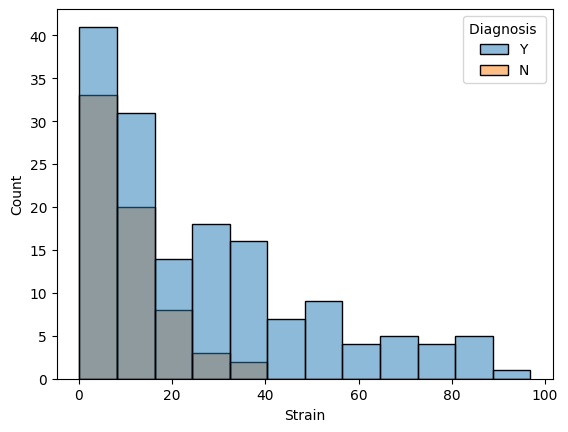

In [86]:
# TODO: Plot a histogram of Strain grouped by diagnosis
sns.histplot(data=matched_df, x="Strain", hue="Diagnosis ")

Ooo, so we do see an expected trend: those with higher strain values tend of have a diagnosis of some sort. What happens if we go even further and incorporate age into it as well?

<Axes: xlabel='Age', ylabel='Strain'>

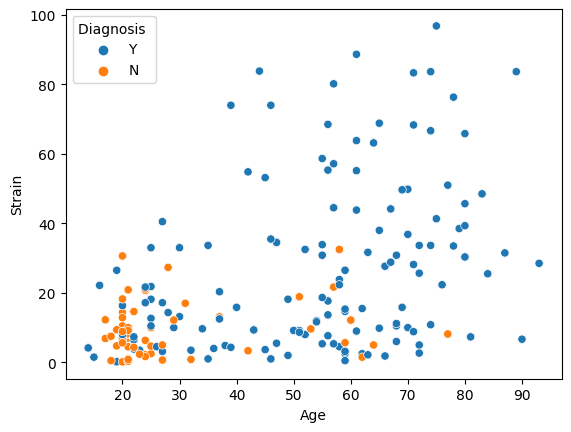

In [87]:
sns.scatterplot(data=matched_df, x="Age", y="Strain", hue="Diagnosis ")

The above plot is a bit "busy", meaning that it's a little overwhelming to look at, but you can see some interesting relationships. One, strain isn't necessarily correlated with age, as old folks still can have relatively unstrained voices (which is to be expected! The rating scale is designed to be normalized across age!).

As before, we do see the same relationship, whereby only those with diagnoses have very high strain values, with the healthiest voice that's strained having a max value of around 40. 

Let's see if we can calcuate some statistics across all the PQs!

In [89]:
matched_df

,File,Breathiness,Loudness,Pitch,Roughness,Strain,Gender,Age,Diagnosis
0,LA7005,7.000000,7.333333,7.000000,8.500000,8.000000,f,52.0,Y
1,PT116,31.833333,12.333333,6.000000,29.500000,7.333333,f,81.0,Y
2,PT034,43.166667,26.666667,61.166667,34.000000,30.333333,f,80.0,Y
3,SJ6006,4.375000,5.125000,0.250000,3.750000,6.875000,f,17.0,N
4,PT005,5.500000,7.000000,12.000000,3.833333,4.500000,f,58.0,Y
...,...,...,...,...,...,...,...,...,...
229,NYU1004,37.500000,35.666667,39.833333,49.166667,30.833333,m,55.0,Y
230,SJ7001,0.333333,0.333333,0.333333,3.000000,0.833333,f,21.0,N
232,PT095,18.500000,12.000000,4.166667,12.500000,21.666667,m,24.0,Y
233,SJ5002,23.500000,10.250000,15.375000,24.625000,8.875000,f,20.0,N


In [109]:
# Here's a df of the PQs and the diagnosis value
pq_and_diagnosis_df = matched_df[["Diagnosis ", "Breathiness", "Loudness", "Pitch", "Roughness", "Strain"]]

# TODO: Calculate the Average, Median, and Max PQ per diagnosis
pq_and_diagnosis_df.groupby("Diagnosis ").agg(["mean", "median", "max"])

Breathiness                    Loudness                        \
                  mean     median   max       mean     median        max   
Diagnosis                                                                  
N             8.810606   5.500000  38.0   4.243687   2.937500  21.833333   
Y            24.064247  16.166667  99.5  24.487097  14.666667  99.166667   

                Pitch                        Roughness                        \
                 mean     median        max       mean     median        max   
Diagnosis                                                                      
N            4.693813   2.333333  20.833333  11.757576  10.166667  44.625000   
Y           22.017742  12.166667  99.166667  25.783602  21.500000  84.833333   

               Strain                        
                 mean     median        max  
Diagnosis                                    
N            9.876894   8.208333  32.500000  
Y           26.199194  18.166667  96.833333

If you computed the above correctly, you should see that the no-diagnosis max value across all PQs is for Roughness at a value of 44.63, with the mean diagnosis for undiagnosed voices being around ~8ish. 

### Visualizing a Lot of Things All at Once

Ok, so it seems like making a plot of all histograms for each PQ would be as simple as a for-loop, and it can be! Arguably this is what you should do if you need to generate a plot for a figure in a paper. But what if you want to do it the fancy way? Then, you're going to convert our wide dataset to a long dataset, and use somethng called a Facet Grid. 

I'm going to provide the code for this below, cause it can be a bit of a hassle. But bear with me :D

In [106]:
# Same df as before, but going to include the File to make it clearer
pq_and_diagnosis_df = matched_df[["File", "Age", "Diagnosis ", "Breathiness", "Loudness", "Pitch", "Roughness", "Strain"]]

# Make a Long DataFrame
long_df = pd.melt(pq_and_diagnosis_df, id_vars = ["File", "Age", "Diagnosis "], value_vars=["Breathiness", "Loudness", "Pitch", "Roughness", "Strain"], var_name = "PQ", value_name = "Value")
long_df.sort_values("File", ascending=False).head(10)

,File,Age,Diagnosis,PQ,Value
438,SJ7001,21.0,N,Loudness,0.333333
659,SJ7001,21.0,N,Pitch,0.333333
1101,SJ7001,21.0,N,Strain,0.833333
880,SJ7001,21.0,N,Roughness,3.000000
217,SJ7001,21.0,N,Breathiness,0.333333
171,SJ6007,17.0,N,Breathiness,9.125000
613,SJ6007,17.0,N,Pitch,0.250000
834,SJ6007,17.0,N,Roughness,19.375000
1055,SJ6007,17.0,N,Strain,12.250000
392,SJ6007,17.0,N,Loudness,1.125000


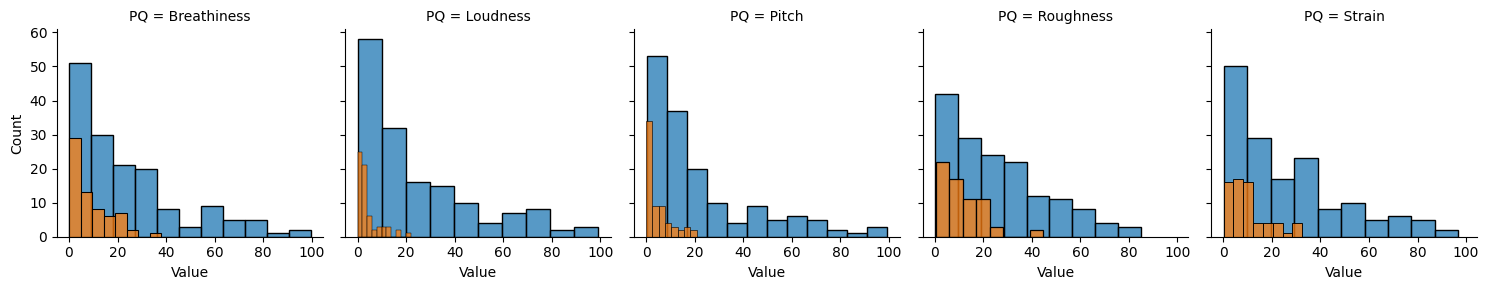

In [107]:
# Make a FacetGrid to plot a lot of things all at once
g = sns.FacetGrid(data=long_df, col = "PQ", hue = "Diagnosis ")
g.map(sns.histplot, "Value")

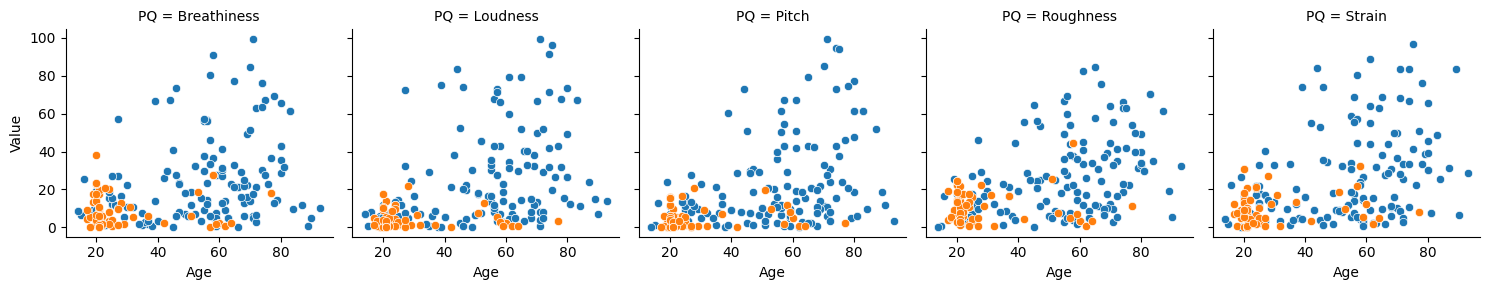

In [108]:
# Make a FacetGrid to plot a lot of things all at once
g = sns.FacetGrid(data=long_df, col = "PQ", hue = "Diagnosis ")
g.map(sns.scatterplot, "Age", "Value")

Visualizing everything together, we see that the same trends hold across PQs, with some PQs having lower max values for undiagnosed voices. 

## Takeaways and Questions

In this notebook, you hopefully gained some experience working with tabular data, seeing a lot of different Pandas techniques in action.

Regarding the PVQD dataset, you should have learned about the general demographic make up, and how that demographic makeup possibly relates to their perceptual qualities. 

Here are some questions to consider!
* What next data exploration steps might you take? 
* How might you combine the above explorations with the audio data--without modeling!
* How might you try and use the discarded data from before?